# Standard light source as a function of gain 
This notebook describes how to measure the number of photons per pixel being emitted from a standard light source over a range of PMT gain settings.
Conducting the protocol over a range of gains is a sanity check: **the photons_per_pixel as a function of gain plot should be a flat line with a slope of 0**.
If there are substantial deviations from this, there is something wrong with the procedure. 
For more technical information on how this approach works and for citations see the repo README file.

# Experimental procedure
We use an 8 kHz resonant-scanning microscope running ScanImage Basic.
The rig has three multi-alkali PMTs (Hama R10699): Channel 2 is "red", channel 3 is "green", and channel 4 is "blue".
The PMTs were preselected by the manufacturer for high gain and low dark current.
The objective is a Nikon 16x NA 0.8. 
The laser source is a Mai Tai eHP DS with a pulse width of roughly 100 fs (not experimentally verified). 

## Materials and methods
## ThorLabs lens paper
The procedure requires a structured target: one that will exhibit a range of mean intensities when imaged. 
Here we use a 10 by 10 mm piece of ThorLabs lens cleaning tissue. 
The tissues is placed on a slide, coverslipped, and sealed completely. 
It must be imaged dry: discard samples where immersion water makes its way under the coverslip. 
The tissue autofluoresces and produces a reasonably bright signal at higher laser powers. 
There is no substantial bleaching and we expect little sample to sample variability. 
The lens paper is imaged at 256 by 256 pixels over 150 frames.
The field of view is roughly 750 µm across, so we are roughly at 3 µm per pixel. 


## Standard tritium light source
The light source is a small vial of tritium coated with a fluorescent subtance. 
It is used in a similar way to that described [here](https://www.biorxiv.org/content/10.1101/2024.01.23.576417v1). 
The only difference being that our standard source holder has no pinhole.
Instead there is an SM05 aperture that allows precise and repeatable placement of the source from recording to recording.  
The tritium vials come in a range of colours.
Here we use a "white" one, which appears blue-shifted to the eye. 

Decay of the tritium excites electrons in the coating which leads light emission. 
During imaging of the vial, the laser is not on: we merely acquire photons.
Consequently there is a single mean level over all pixels (discounting dwell time changes across scan lines due to the resonant scanner). 

## Procedure
Since the standard source "image" contains pixels with only a single mean intensity, we can not use this to directly calculate the quantal size (the number of raw values per photon). 
We first image the structured lens paper target at a range of gains for each channel. 
For unimportant reasons there is one image stack per channel per gain. 
So the channels are imaged sequentially here, which in a real production protocol would not be the case.  

The structured target is then swapped for the standard tritium vial light source. 
This was imaged over the same gains as the lens paper and at the same image size: 256  by 256.
The image sizes of the two samples **must** be the same. 
The pixel integration time will vary linearly with the number of pixels per line and so this affects the number of recorded photons per pixel. 
All three channels were acquired simultaneously here.
Only one frame was acquired, as this produces plenty of data to calculate a reliable mean pixel intensity. 

This notebook shows how to calculate the offset and quantal size from the lens paper then use those values to convert the standard source to photons/pixel. 


# Note on code
We use "poisson-codecs" which has been forked from [github.com/neuroinformatics-unit/poisson-numcodecs](https://github.com/neuroinformatics-unit/poisson-numcodecs) to [https://github.com/raacampbell/poisson-numcodecs](github.com/raacampbell/poisson-numcodecs).
There is more information on the origin of this toolkit in the main repo README file.
The main reason for the fork is to tweak the code slightly to add a function input argument associated with clipping very low means when calculating the fits. This is only used for the last couple of figures in the notebook and seems not to be significant. 

To run the notebook you should download the code from [raacampbell/poisson-numcodecs](https://github.com/raacampbell/poisson-numcodecs) then `pip install -e .`. 

# Data
You may read through the notebook below.
If you wish to re-run it, you will need to download the data from [gin.g-node.org/SWC_AMF/NV_photon_calibration_250122](https://gin.g-node.org/SWC_AMF/NV_photon_calibration_250122) and set the `im_path` variable in the second cell to the path of the data. 

# Preamble

In [1]:
import os
import re
from glob import glob
import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt
from poisson_numcodecs import Poisson, calibrate

In [2]:
## Define the relative or absolute path to the image data
# EDIT THIS IF YOU WANT TO RE-RUN THE ANALYSIS

im_path = '/Users/rob/LOCAL/RoCa_2025_Q1_Photon_QC/NeuroVision__2025_01_22'


In [3]:
## Define to useful functions we will use later


def get_tiff_files_for_channel(chanNumber: int):
    # Find all structured target TIFF files from a defined channel
    #
    # INPUTS
    # chanNumber: integer between 2 and 4 indicating which channel to search for
    #
    # RETURNS
    # A list of paths to the requesteed TIFF files

    tiff_files = glob( os.path.join(im_path,f'N*_Channel_{chanNumber}_*.tif') )
    return sorted(tiff_files)
    


def fit_and_plot(imfname: str, suppress_image_plot=False, count_weight_gamma: float=0.2, min_percent_max: float=3):
    # Simple function to show the mean image converted to photons and the fit that underlies this
    #
    # Inputs
    # imfname -- path to image
    # suppress_image_plot -- if True the mean plot is not shown
    # min_percent_max -- 3 by default. The minimum fitted value will 3% of the maximum or 
    #          the minumum found by the calibration function, whichever is larger. 
    
    im = tiff.imread(imfname)
    im = im - np.min(im) # Our data have a large negative offset, which we remove here. 
                         # The FITS WILL FAIL if this is not removed

    # Create the calibration object and fit the variance/mean line.
    # photon_sensitivity (also known as the quantal size) is the slope and dark_signal is the x axis 
    # intercept, which is the raw data value corresponding to zero signal. 
    calibrator = calibrate.SequentialCalibratePhotons(im)
    [photon_sensitivity, dark_signal] = calibrator.get_photon_sensitivity_parameters(count_weight_gamma=count_weight_gamma, min_percent_max=min_percent_max)

    # Plot the mean/variance fit plot
    calibrator.plot_poisson_curve()

    # Convert the original data to photons (this just subtracts dark_signal and divides by photon_sensitivity)
    M=calibrator.get_photon_flux_movie()

    if not suppress_image_plot:
        plt.figure()
        plt.imshow(np.mean(M,axis=0))
        plt.title(('mean photon count: %0.2f' % np.mean(M)))
        plt.colorbar()

    # Print to screen the key stats
    print(os.path.split(imfname)[-1])
    print(f'Quantal size: %0.2f, Zero level: %0.1f, mean photon count: %0.2f' % (photon_sensitivity, dark_signal, np.mean(M)))

# Example fit
Quickly read and plot some data from a medium gain reocording of the lens paper structured source. 

NeuroVision_lens_paper_641V_780nm_100mW_Channel_3_2025-01-22.tif
Quantal size: 134.57, Zero level: 273.8, mean photon count: 3.30


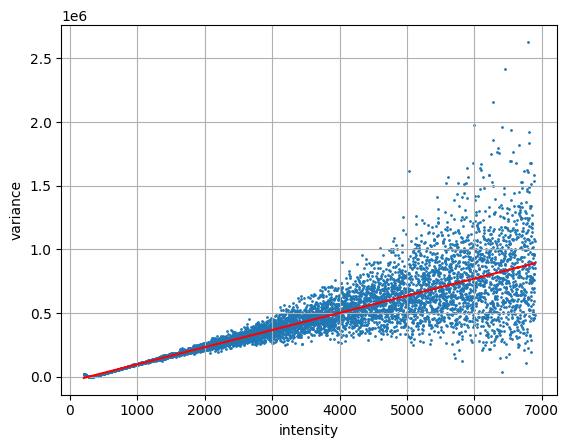

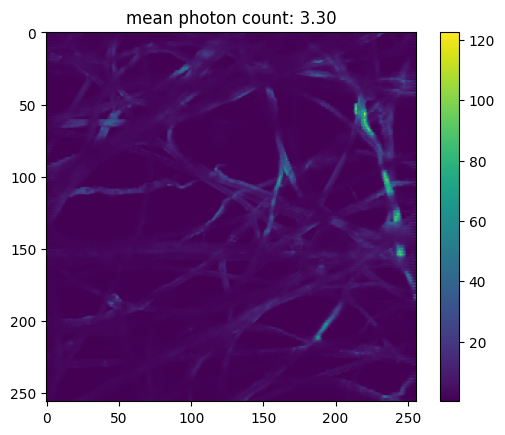

In [4]:
ii=7
tiff_files = get_tiff_files_for_channel(3)

if len(tiff_files)>0:
    fit_and_plot(tiff_files[ii])
else:
    print(f'Found no TIFF files in path {im_path}')


# Batch process all structured lens paper images
Here we will go through all the lens paper data and calculate and record for each:
1. The image minimum value. All data are negatively offset at the pre-amplifier. This is arbitrary and the fits require positive values. So and we subtract this offset for both structured targets and the standard source.
2. The quantal size.
3. The image zero level. This is the raw value associated with zero photons and is distinct from the image minumum value, above. 

## Note on parameters
The analysis in the function below is run with a `count_weight_gamma` of `0.8`. Running at, say `0.3`, produces similar results but with more variability over gains and with the quantal size as a function of gain plot looking less smooth.
This parameter is a weighting coefficient for the robust fit. 
The photons/pixel parameter does change a bit with different `count_weight_gamma` values: usually by one or two photons. 
However, this is a lot considering that we are dealing with no more than about 10 photons per pixel. 
It remains to be seen whether this error is a real concern: this will become apparent when this protocol becomes used to compare results from different microscopes. 

In [5]:
## 
# Define variables and function that will read through all lens paper image stacks and convert all to photons for one channel

# pre-allocate arrays
tiff_files =  get_tiff_files_for_channel(2)
gains = np.zeros((3,len(tiff_files)))
zero_levels = np.zeros((3,len(tiff_files)))
qSize = np.zeros((3,len(tiff_files)))
photons = np.zeros((3,len(tiff_files)))
image_mins = np.zeros((3,len(tiff_files)))

def get_all_mean_counts(chanId: int, verbose=False):
    # To get data from all stacks of one channel
    #
    # Inputs
    # chanId - the channel index (2 to 4) to process.
    #
    # Outputs
    # A list of statistics that 

    tiff_files =  get_tiff_files_for_channel(chanId)

    gains = []
    zero_level = []
    qSize = []
    photons = []
    image_min = []

    for t_file in tiff_files:
    
        gain = int((re.findall('_(\d+)V_',t_file))[0])
        if gain == 0:
            continue
    
        t_data = tiff.imread(t_file)
        im_min = np.min(t_data)
        t_data = t_data - im_min # we store this because it might be useful for the standard source data
        calibrator = calibrate.SequentialCalibratePhotons(t_data)

        ##
        # * NOTE: the input argument is the count weight. Changing this will inflidence the results.
        # See readme section at top of notebook.
        [photon_sensitivity, dark_signal] = calibrator.get_photon_sensitivity_parameters(count_weight_gamma=0.8)
    
        M=calibrator.get_photon_flux_movie()
        gains.append(gain)
        zero_level.append(dark_signal)
        qSize.append(photon_sensitivity)
        photons.append(np.mean(M))
        image_min.append(im_min)

        if verbose:
            print(f'Quantal size: %0.2f, Zero level: %0.1f, Gain: %dV, mean photon count: %0.2f' % 
                   (photon_sensitivity, dark_signal, gain,np.mean(M)) )

    return(np.array(gains), np.array(qSize), np.array(zero_level), np.array(photons), np.array(image_min))


In [6]:
# Read through everything and convert all to photons for channels 3 and 4

for ii in np.arange(3): 
    chan = ii+2
    print('Processing channel %d' % chan)
    (gains[ii],qSize[ii],zero_levels[ii],photons[ii],image_mins[ii]) = get_all_mean_counts(chan)


Processing channel 2
Processing channel 3
Processing channel 4


## Plotting time!
We now have the calculated statistics obtained from all gains and all channels of the standard source. 
Let's look at them. 
Are photons per pixel really flat over gains?

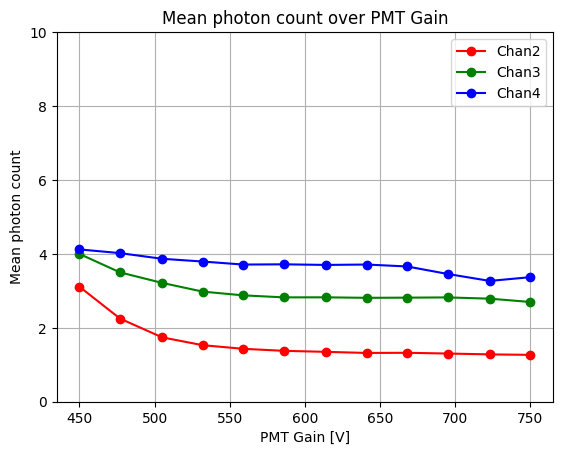

In [7]:
# Plot mean photon count of calibration data as a function of PMT gain
plt.plot(gains[0],photons[0],'ro-')
plt.plot(gains[1],photons[1],'go-')
plt.plot(gains[2],photons[2],'bo-')

plt.grid()

plt.xlabel('PMT Gain [V]')
plt.ylabel('Mean photon count')
plt.title('Mean photon count over PMT Gain')
plt.legend(('Chan2','Chan3','Chan4'));
plt.ylim((0,10));

Photon counts are pretty flat over gains with a `count_weight_gamma` of 0.8 (as shown above). 
At `count_weight_gamma=0.2` there is more variability, especially at gains <500 V (data not shown).

Let's now plot quantal size and the offset value over gain before going on to produce calibrated images of the standard source. 


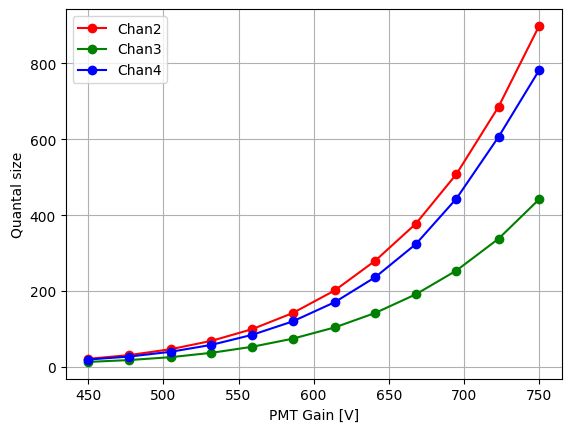

In [8]:
# Plot mean photon count of calibration data as a function of PMT gain
plt.plot(gains[0],qSize[0],'ro-')
plt.plot(gains[1],qSize[1],'go-')
plt.plot(gains[2],qSize[2],'bo-')

plt.grid()

plt.xlabel('PMT Gain [V]')
plt.ylabel('Quantal size')
plt.legend(('Chan2','Chan3','Chan4'));

Those plots looks smooth and reasonable, as expected. Next let's look at zero level as a function of gain. 

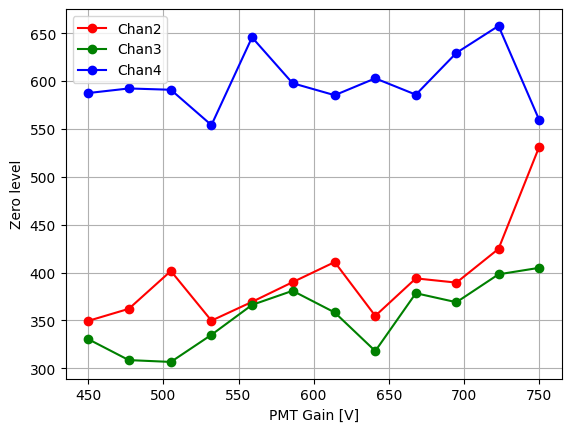

In [9]:
# Plot mean photon count of calibration data as a function of PMT gain
plt.plot(gains[0],zero_levels[0],'ro-')
plt.plot(gains[1],zero_levels[1],'go-')
plt.plot(gains[2],zero_levels[2],'bo-')

plt.grid()

plt.xlabel('PMT Gain [V]')
plt.ylabel('Zero level')
plt.legend(('Chan2','Chan3','Chan4'));

This looks fairly flat, which is expected. Changing gain should not alter the X intercept.

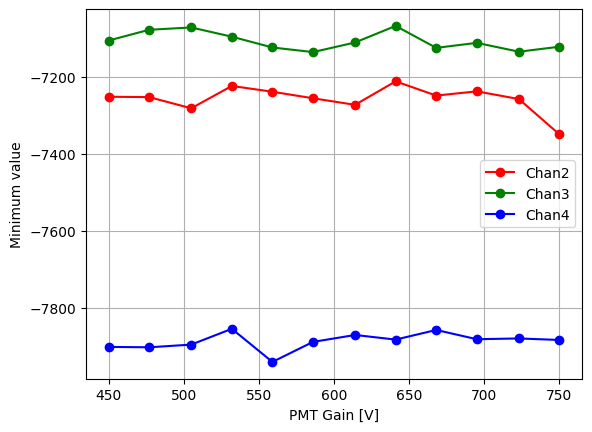

In [10]:
# Plot mean photon count of calibration data as a function of PMT gain
plt.plot(gains[0],image_mins[0],'ro-')
plt.plot(gains[1],image_mins[1],'go-')
plt.plot(gains[2],image_mins[2],'bo-')

plt.grid()

plt.xlabel('PMT Gain [V]')
plt.ylabel('Minimum value')
plt.legend(('Chan2','Chan3','Chan4'));

The minimum values are important because will be adding this offset (it's negative) to the standard source before subtracting the "zero value" (x intercept of the fit).  Let's next convert the standard source to photons based on the above.

## Standard source in photons
We now remove the lens paper and acquire an "image" of the standard source. The laser is off here. We instead just take one frame where every pixel value is a measurement of the standard source. The correction of the resonant scanner could impact measurments, as pixel dwell times effectively differ over the image. For now we ignore this.  

In [11]:
# now use the above to calibrate the standard source data acquired during the same session
ssDir = 'NeuroVision_standard_light_source_White_2024Q2__2025-01-22_10-20' # The sub-directory containing the standard source images
ssFiles = sorted(glob(os.path.join(im_path,ssDir,'*.tif')));

converted_means = np.zeros((len(ssFiles),3)) # The standard source images converted to mean photons per pixel

ii = 0
for t_file in ssFiles: # Loop over gains (one per file)
        
    t_data = tiff.imread(t_file)
    mu = np.mean(t_data[1:],axis=(1,2)) #Average of the three channels

    t_gain = int((re.findall('_(\d+)V_',t_file))[0])
    
    # Convert each channel to photons
    #  (channel_mean - zero_level- minimum_pixel_value_from_lens_paper) / quantal_size
    converted = (mu.flatten() - 
                (zero_levels[:,gains[0]==t_gain]).flatten() - 
                 (image_mins[:,gains[0]==t_gain]).flatten()) / (qSize[:,gains[0]==t_gain]).flatten()
  
    converted_means[ii,:] = converted
    ii += 1

(5.5, 12.0)

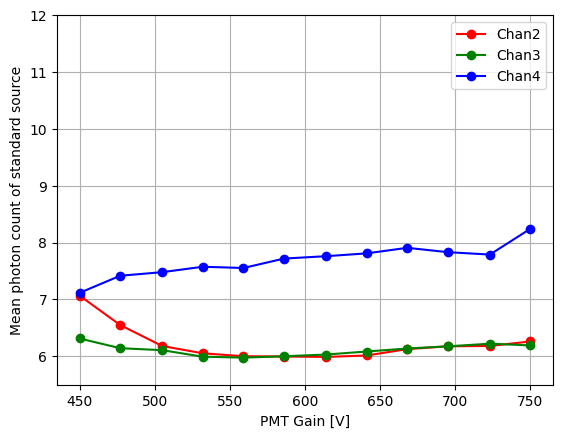

In [28]:
# Plot standard light source mean photon count as a function of PMT gain
plt.plot(gains[0],converted_means[:,0],'ro-')
plt.plot(gains[1],converted_means[:,1],'go-')
plt.plot(gains[2],converted_means[:,2],'bo-')

plt.grid()

plt.xlabel('PMT Gain [V]')
plt.ylabel('Mean photon count of standard source')
plt.legend(('Chan2','Chan3','Chan4'));
plt.ylim((5.5,12))

# Outcome
The mean photons per pixel for the standard source is basically constant over gain.
To achieve the above plot, the standard source **must** have the minimum value from lens paper subtracted from it. 
Otherwise the results are all over the place for low gains.
We must also be using the same dwell times for the structured source and the standard source. 

# Further analysis

## Tail at low values
The data at lower gain values have a funny kink at intensity values smaller than the X intercept. 
Does removing this with the `min_percent_max` parameter make any difference to the fits?

NeuroVision_lens_paper_532V_780nm_100mW_Channel_4_2025-01-22.tif
Quantal size: 54.75, Zero level: 518.4, mean photon count: 4.70


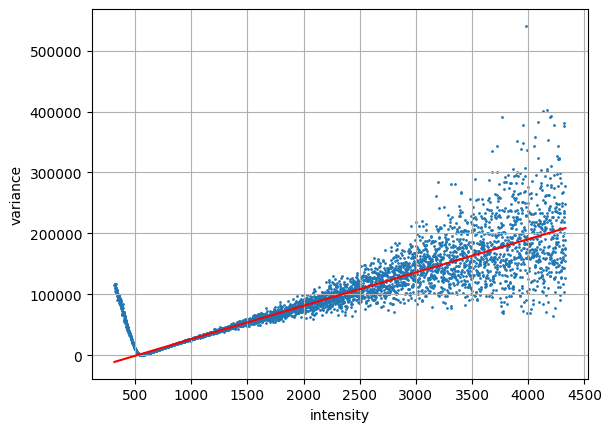

In [15]:
# Let's look at this plot
fname = os.path.join(im_path,'NeuroVision_lens_paper_532V_780nm_100mW_Channel_4_2025-01-22.tif')
fit_and_plot(fname, suppress_image_plot=True)


NeuroVision_lens_paper_532V_780nm_100mW_Channel_4_2025-01-22.tif
Quantal size: 55.26, Zero level: 529.3, mean photon count: 4.45


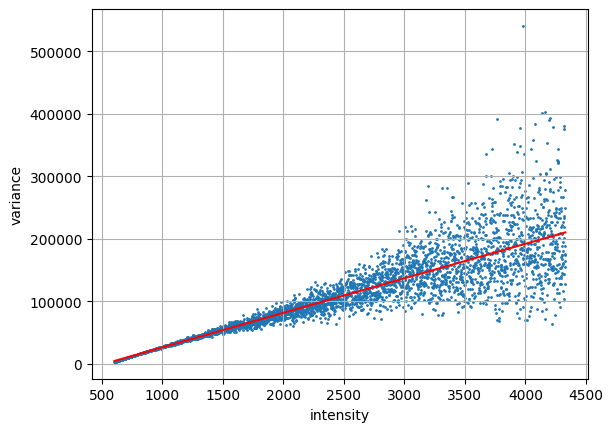

In [16]:
# Let's see if removing the wierd tail at low intensity levels makes any difference. 
fit_and_plot(fname, suppress_image_plot=True, min_percent_max=14)


Removing the weird low-value tail in the fit makes no real difference to the intercept or slope. 

## Dealing with the funny distribution at higher gains
Higher gains have weird distriubtion. Maybe this is because of increasing dark counts. Compare two similar gain values and see how the distribition changes in the higher one.
First we look at the blue channel

NeuroVision_lens_paper_641V_780nm_100mW_Channel_4_2025-01-22.tif
Quantal size: 216.57, Zero level: 365.8, mean photon count: 5.15


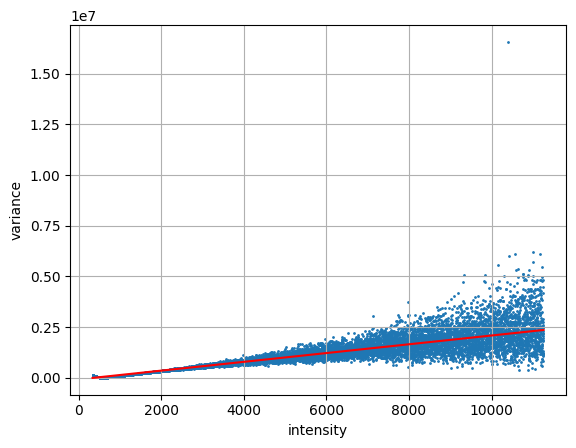

In [21]:
fname = os.path.join(im_path,'NeuroVision_lens_paper_641V_780nm_100mW_Channel_4_2025-01-22.tif')
fit_and_plot(fname, suppress_image_plot=True)


NeuroVision_lens_paper_723V_780nm_100mW_Channel_4_2025-01-22.tif
Quantal size: 560.63, Zero level: 0.0, mean photon count: 4.71


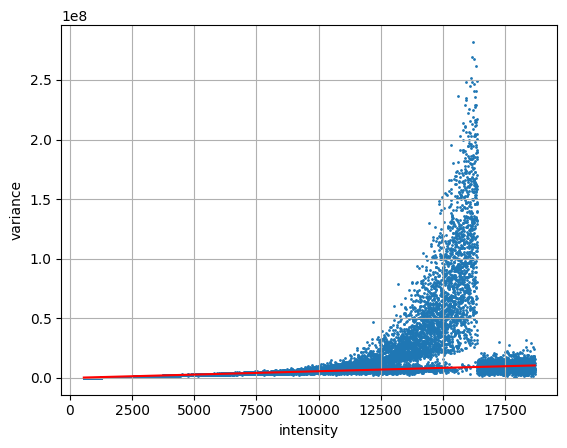

In [22]:
fname = os.path.join(im_path,'NeuroVision_lens_paper_723V_780nm_100mW_Channel_4_2025-01-22.tif')
fit_and_plot(fname, suppress_image_plot=True)

Does this happen at other PMTs too?

NeuroVision_lens_paper_750V_780nm_100mW_Channel_3_2025-01-22.tif
Quantal size: 392.88, Zero level: -0.0, mean photon count: 4.07


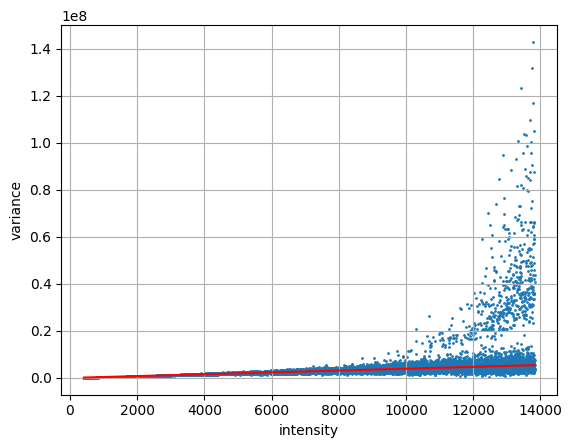

In [24]:
# The Green PMT
fname = os.path.join(im_path,'NeuroVision_lens_paper_750V_780nm_100mW_Channel_3_2025-01-22.tif')
fit_and_plot(fname, suppress_image_plot=True)

NeuroVision_lens_paper_750V_780nm_100mW_Channel_2_2025-01-22.tif
Quantal size: 780.49, Zero level: -0.0, mean photon count: 2.14


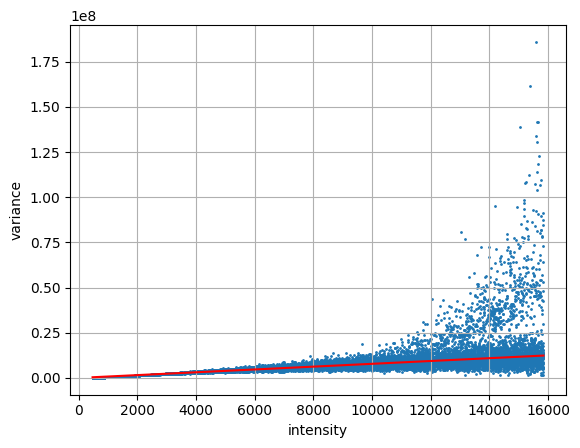

In [25]:
# The Red PMT
fname = os.path.join(im_path,'NeuroVision_lens_paper_750V_780nm_100mW_Channel_2_2025-01-22.tif')
fit_and_plot(fname, suppress_image_plot=True)

Yes, this is common but the degree to which it happens varies. Maybe this is because different absolute gains of different PMTs: they come out of the factory with a lot of variability between units.

How does the `count_weight_gamma` parameter influenced photons per pixel for these distributions? 
Let's go back to the blue PMT at 723 V, where we originally got this at a `count_weight_gamma` of `0.2` (note the bulk of the analyses above were done at `0.8`) :
```
NeuroVision_lens_paper_723V_780nm_100mW_Channel_4_2025-01-22.tif
Quantal size: 560.63, Zero level: 0.0, mean photon count: 4.71
```

So if we re-run at `0.8`?

NeuroVision_lens_paper_723V_780nm_100mW_Channel_4_2025-01-22.tif
Quantal size: 606.10, Zero level: 657.6, mean photon count: 3.27


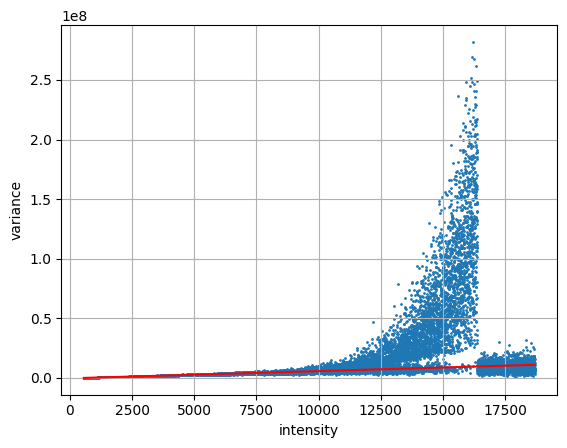

In [26]:
fname = os.path.join(im_path,'NeuroVision_lens_paper_723V_780nm_100mW_Channel_4_2025-01-22.tif')
fit_and_plot(fname, suppress_image_plot=True, count_weight_gamma=0.8)

Mean photon count has gone down from 4.71 to 3.27 and we have a non-zero value for the x intercept, which seems more reasonable.